# 🤖 BFM-Zero Latent Z Inference Tutorial

<div align="center">

**A comprehensive guide to using BFM-Zero for behavioral foundation model inference**

[![Python](https://img.shields.io/badge/Python-3.8+-blue.svg)](https://www.python.org/)
[![MuJoCo](https://img.shields.io/badge/MuJoCo-3.0+-green.svg)](https://mujoco.org/)
[![PyTorch](https://img.shields.io/badge/PyTorch-2.0+-orange.svg)](https://pytorch.org/)

</div>

---

## 📚 Table of Contents

1. [Introduction](#introduction)
2. [Setup & Configuration](#setup--configuration)
3. [Understanding Model & Observation Structure](#understanding-model--observation-structure)
4. [Inference Examples](#inference-examples)
   - 4.1 [Reward Inference](#41-reward-inference)
   - 4.2 [Goal Inference](#42-goal-inference)
   - 4.3 [Tracking Inference](#43-tracking-inference)
5. [ONNX Export](#onnx-export)

---

## 🎯 Introduction

This notebook demonstrates how to perform **three types of latent z inference** with BFM-Zero, a behavioral foundation model for humanoid robot control.

### What is BFM-Zero?

**BFM-Zero** is a behavioral foundation model that uses a **latent space** to encode desired behaviors. By inferring different `z` values, you can control a humanoid robot to perform various tasks without retraining the model.

### Inference Types

| Inference Type | Description | Use Case |
|---------------|-------------|----------|
| 🎁 **Reward Inference**   | Infers latent `z` from reward-weighted observations | Optimize for specific reward functions (e.g., locomotion speed, rotation, arm movements) |
| 🎯 **Goal Inference**    | Infers latent `z` for goal-reaching tasks | Reach a target pose or state (e.g., T-pose, specific joint configuration) |
| 📹 **Tracking Inference** | Infers latent `z` for motion tracking | Follow a reference motion trajectory (e.g., dance, walking, complex movements) |

### Key Concepts

- **Latent `z`**: A 256-dimensional vector that encodes desired behaviors
- **Observation**: Robot state information (joint positions, velocities, history, etc.)
- **Policy**: Takes `(observation, latent_z)` → produces `actions` (joint torques)
- **Inference**: The process of finding the right `z` for a desired behavior


## 📦 Setup & Configuration

This section sets up the environment and imports all necessary libraries for BFM-Zero inference.



In [1]:
import joblib
import mujoco
import mujoco_warp as mjw
import numpy as np
import os
import yaml

import torch
from scipy.spatial.transform import Rotation
from IPython.display import Video, display
from PIL import Image as PILImage
from torch.amp import autocast
# Try to import viewer (available in MuJoCo 3.0+)
try:
    import mujoco.viewer
    HAS_VIEWER = True
except (ImportError, AttributeError):
    HAS_VIEWER = False
    print("Note: mujoco.viewer not available. Interactive viewer will be disabled.")

# Try to import imageio for video saving
try:
    import imageio
    try:
        import imageio.plugins.ffmpeg
        HAS_FFMPEG = True
    except:
        HAS_FFMPEG = False
        print("Note: imageio[ffmpeg] not installed. Install with: pip install imageio[ffmpeg]")
except ImportError:
    imageio = None
    HAS_FFMPEG = False
    print("Note: imageio not available. Video saving will be disabled.")

from torch.utils._pytree import tree_map
from bfm_zero_inference_code.fb_cpr_aux.model import FBcprAuxModel
from bfm_zero_inference_code.inference.rewards import (
    MJWArmsReward,
    MJWLocomotionReward,
    MJWMoveArmsReward,
    MJWRotationReward,
    MJWSitOnGroundReward,
    MJWSpinArmsReward,
)
# Import common configuration values
from common import ACTION_SCALES, KP_GAINS, KD_GAINS, DEFAULT_JOINT_POS, ACTION_RESCALE

Note: imageio[ffmpeg] not installed. Install with: pip install imageio[ffmpeg]


### Configure Paths and Constants

Set up paths to model files, robot XML, and sample data.


In [ ]:
MODEL_PATH = "./model/oct7_base/checkpoint/model"

# Get the current directory (works in both scripts and notebooks)
# In notebooks, use current working directory instead of __file__
_THIS_FILE_DIR = os.getcwd()
SAMPLE_DATA_FILE = os.path.join(_THIS_FILE_DIR, "sample_data.npz")

ROBOT_XML = str("bfm_zero_inference_code/g1_for_reward_inference.xml")
QPOS_DIM = 29 + 7  # 29 dof + 7 freejoint

# Create video directory for saving all simulation videos
VIDEO_DIR = "videos"
os.makedirs(VIDEO_DIR, exist_ok=True)


## 🔍 Understanding Model & Observation Structure

Before using BFM-Zero for inference, it's important to understand:
- **Model architecture**: How the model processes observations and latent `z`
- **Observation format**: What information the model expects
- **Latent `z`**: How behaviors are encoded
- **Policy output**: What actions the model produces

### Load Model

Use `FBcprAuxModel.load()` to load a pre-trained BFM-Zero model from disk. The model contains:
- **Actor network**: Generates actions from observations and latent `z`
- **Backward map**: Infers latent `z` from observations
- **Forward map**: Predicts next observations from current state, `z`, and actions
- **Observation normalizer**: Normalizes input observations

In [3]:
# Load the model
model = FBcprAuxModel.load(MODEL_PATH, device="cpu")


### Check Observation Structure

Use `model.obs_space.sample()` to inspect the observation structure. The observation is a dictionary containing:

- **`state`**: Current robot state (joint positions, velocities, gravity, angular velocity)
- **`history_actor`**: Historical information (previous actions, states over 4 timesteps)
- **`last_action`**: Previous action taken by the policy
- **`privileged_state`**: Additional information (not used during policy inference)

In [4]:
# Sample an observation to see its structure
observation = model.obs_space.sample()

print("📊 OBSERVATION STRUCTURE")
print("=" * 60)
print(f"Type: {type(observation)}")
if isinstance(observation, dict):
    print(f"\nKeys: {list(observation.keys())}")
    print("\nComponent Details:")
    for key, value in observation.items():
        if hasattr(value, 'shape'):
            print(f"  • {key:20s}: shape={str(value.shape):15s}")
        else:
            print(f"  • {key:20s}: {type(value)}")
else:
    print(f"Shape: {observation.shape if hasattr(observation, 'shape') else 'N/A'}")


📊 OBSERVATION STRUCTURE
Type: <class 'dict'>

Keys: ['history_actor', 'last_action', 'privileged_state', 'state']

Component Details:
  • history_actor       : shape=(372,)         
  • last_action         : shape=(29,)          
  • privileged_state    : shape=(463,)         
  • state               : shape=(64,)          


### Check Latent Z

The latent `z` is a vector that encodes desired behaviors. 

- Dimension: `D (e.g. 256)`
- Normalized: `||z|| = sqrt(D) (e.g. = 16)`

Use `model.project_z()` to project the latent vector onto a hypersphere (normalized to have `sqrt(256) = 16` norm).

In [5]:
# Create a random latent z (with time-based seed for different values each run)
print("🎨 LATENT Z (Behavior Encoding)")
print("=" * 60)
print(f"Latent z is a {model.cfg.archi.z_dim}-dimensional vector that encodes desired behaviors.")
print("Let's create a random z and see how the policy uses it:\n")

import time
torch.manual_seed(int(time.time() * 1000) % 2**32)  # Use current time as seed
random_z = torch.randn(model.cfg.archi.z_dim) 
random_z = model.project_z(random_z)

print(f"Random z shape: {random_z.shape}")
print(f"Random z norm: {random_z.norm():.2f}")


🎨 LATENT Z (Behavior Encoding)
Latent z is a 256-dimensional vector that encodes desired behaviors.
Let's create a random z and see how the policy uses it:

Random z shape: torch.Size([256])
Random z norm: 16.00


### Check Policy Output

Use `model.act(observation, z)` to get actions from the policy. The policy takes:
- **Input**: `(observation, latent_z)`
- **Output**: `actions` (29-dimensional vector of joint torques)

The policy uses the latent `z` to modulate its behavior, allowing different `z` values to produce different motion styles.

In [6]:
# Policy inference: Takes observation + latent z → produces actions
print("🤖 Policy Output")
print("=" * 60)

def get_action_from_policy(model, obs, latent_z):
    """
    Get action from policy given observation and latent z.
    
    Args:
        obs: Observation dict
        latent_z: Latent z vector (256 dim) for the policy
    
    Returns:
        action: Action from policy (29 dim numpy array)
    """
    # Convert latent_z to tensor if needed
    if not isinstance(latent_z, torch.Tensor):
        latent_z = torch.tensor(latent_z, dtype=torch.float32)
    
    # Convert observation to torch tensors and add batch dimension
    obs_torch = tree_map(lambda x: torch.tensor(x).unsqueeze(0), obs)
    
    # Get action from policy
    with torch.no_grad():
        action = model.act(obs_torch, latent_z.unsqueeze(0), mean=True)
    
    return action[0].cpu().numpy()
    
output = get_action_from_policy(model, observation, random_z)

print(f"\nPolicy output (actions) shape: {output.shape}")

🤖 Policy Output

Policy output (actions) shape: (29,)


### 📖 Understanding the Observation Components

Now that we've seen the structure, let's understand what each component means:

| Component | Dimensions | Description |
|-----------|------------|-------------|
| `state` | 64 | Current robot state: `[dof_pos (29) + dof_vel (29) + projected_gravity (3) + ang_vel (3)]` |
| `history_actor` | 372 | History buffer: `[prev_actions (116) + ang_vel_history (12) + dof_pos_history (116) + dof_vel_history (116) + projected_gravity_history (12)]` |
| `last_action` | 29 | Previous action taken (used for action smoothing) |
| `privileged_state` | 463 | Additional privileged information (not used during policy inference) |

**Key Points:**
- 🎯 **`privileged_state`**: Contains extra information but is **not used** during policy inference. Only included for compatibility.
- 🎨 **Latent `z`**: A 256-dimensional vector normalized to have `sqrt(256) = 16` norm (lies on a hypersphere).
- 🤖 **Policy**: Takes `(observation, latent_z)` → produces `actions` (29-dimensional joint torques).
- 📊 **History**: The `history_actor` contains information from the last 4 timesteps, helping the policy make smoother, more stable decisions.

---

### 🎬 Example: Random Latent Z

Let's see what happens when we use a random latent z to control the robot:


In [7]:
# Example: Run policy with random latent z
from env import MuJoCoBFMZeroEnv

# Initialize environment with video recording
env = MuJoCoBFMZeroEnv(
    robot_xml=ROBOT_XML,
    kp_gains=KP_GAINS,
    kd_gains=KD_GAINS,
    default_joint_pos=DEFAULT_JOINT_POS,
    action_scales=ACTION_SCALES,
    action_rescale=ACTION_RESCALE,
    enable_video=True,
    video_path="videos/random_z_simulation.mp4",
    video_fps=50  # Higher FPS for smoother playback
)

# Reset environment
obs = env.reset()
print("🚀 Running simulation with random latent z...")
print(f"Initial root height: {env.mjd.qpos[2]:.4f}\n")

# Run simulation (fewer steps for faster video)
num_steps = 100
for step in range(num_steps):
    # Get action from policy using random z
    action = get_action_from_policy(model, obs, random_z)
    
    obs, next_obs, reward, info = env.step(action)
    obs = next_obs
    
    # Print progress every 50 steps
    if step % 100 == 0:
        print(f"Step {step:4d}: Root height = {info['root_height']:.4f}, Position = {info['root_position']}")

print("\n✅ Simulation complete!")

# Save video
if env.enable_video:
    env.save_video()
    print(f"🎥 Video saved to: {env.video_path}")
    
    # Display video in notebook
    print("\n📹 Video Preview:")
    display(Video(env.video_path, width=640, height=480))


🚀 Running simulation with random latent z...
Initial root height: 0.7930

Step    0: Root height = 0.7909, Position = [-3.17786381e-03 -1.12531402e-04  7.90933606e-01]


/var/folders/ph/vp01txj919bdr9qfh3vcr0d40000gn/T/ipykernel_18722/1061178654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_torch = tree_map(lambda x: torch.tensor(x).unsqueeze(0), obs)



✅ Simulation complete!
Attempting to save as GIF instead, or install with: pip install imageio[ffmpeg]
Will save as: videos/random_z_simulation.gif
Saving 100 frames to videos/random_z_simulation.gif...
Error saving video: local variable 'imageio' referenced before assignment
🎥 Video saved to: videos/random_z_simulation.mp4

📹 Video Preview:


# 🤖 BFM-Zero Latent Z Inference Tutorial

## 🎁 1. Reward Inference

Reward inference allows you to: 🎯 Find behaviors that maximize a given reward function


### 🔧 Helper Function: Reward Relabeling

The `relabel_rewards()` function computes rewards for a batch of robot states using **MuJoCo Warp** for efficient parallel computation.

**Features:**
- **Batch processing**: Computes rewards for multiple states simultaneously
- **GPU acceleration**: Uses MuJoCo Warp for parallel computation (much faster than sequential)
- **Flexible reward functions**: Works with any reward function (locomotion, rotation, arms, etc.)

> 💡 **Tip**: MuJoCo Warp enables GPU-accelerated parallel reward computation, making it 10-100x faster than sequential computation for large batches.


In [8]:
def relabel_rewards(qpos, qvel, ctrl, reward_function, batch_size=100):
    """
    Compute rewards for a batch of states using MuJoCo Warp.
    
    Args:
        qpos: Joint positions
        qvel: Joint velocities
        ctrl: Control actions
        reward_function: Reward function to apply
        batch_size: Batch size for parallel computation
    
    Returns:
        rewards: Computed rewards for each state
    """
    mjm = mujoco.MjModel.from_xml_path(ROBOT_XML)
    m = mjw.put_model(mjm)
    d = mjw.make_data(mjm, nworld=batch_size, nconmax=200)
    rewards = torch.zeros(qpos.shape[0], dtype=torch.float32)
    for i in range(0, qpos.shape[0], batch_size):
        mb = min(batch_size, qpos.shape[0] - i)
        if mb < batch_size:
            d = mjw.make_data(mjm, nworld=mb, nconmax=200)
        aa = reward_function(mjm, m, d, qpos[i : i + mb], qvel[i : i + mb], ctrl[i : i + mb])
        rewards[i : i + mb] = aa

    return rewards


### 🔑 Implementation Steps

1. ✅ **Load sample data** containing robot states (`qpos`, `qvel`, `actions`, `next_obs`)
   - Ideally ~100k+ samples from diverse LAFAN motions
2. ✅ **Compute rewards** for each sample using a reward function:
   - `MJWLocomotionReward()`: Optimize for forward/backward movement
   - And more...
3. ✅ **Infer reward-weighted latent z** using `model.reward_wr_inference(next_obs, rewards)`
   - This weights observations by their rewards and finds the optimal `z`

> 💡 **Tip**: Samples from LAFAN motions work best with BFM-Zero since the model was trained on similar data.

In [9]:
def reward_inference_example():
    # Load up the agent
    model = FBcprAuxModel.load(MODEL_PATH, device="cpu")

    # See load_data_from_motionlib.py for example using the motionlib .pkl files
    # Ideally you should have at least ~100k samples (more is better. Samples from LAFAN motions work best with BFM-Zero)
    sample_data = np.load(SAMPLE_DATA_FILE)
    qpos = sample_data["qpos"]
    qvel = sample_data["qvel"]
    ctrl = sample_data["action"]
    next_obs = {
        "state": torch.tensor(sample_data["next_obs.state"], dtype=torch.float32),
        "privileged_state": torch.tensor(sample_data["next_obs.privileged_state"], dtype=torch.float32),
        "last_action": torch.tensor(sample_data["next_obs.last_action"], dtype=torch.float32),
    }

    # Pick your reward function (e.g., this is move-ego-0-3)
    reward_function = MJWLocomotionReward()
    reward_function.move_speed = 0.5  # Set move_speed attribute after instantiation
    reward_function.move_angle = 0  # Set move_speed attribute after instantiation
    rewards = relabel_rewards(qpos, qvel, ctrl, reward_function, batch_size=100)
    rewards = torch.tensor(rewards, dtype=torch.float32)

    z_reward = model.reward_wr_inference(next_obs, rewards)

    print("Inferred reward-weighted latent z 's shape:", z_reward.shape)
    print(f"Reward-weighted latent z norm: {torch.norm(z_reward):.2f}")
    return z_reward

z_reward = reward_inference_example()



Warp 1.11.0.dev20251130 initialized:
   Git commit: af1e0dd7ee79bb6699d81cd0cdb060ac5c019e32
   CUDA not enabled in this build
   Devices:
     "cpu"      : "arm"
   Kernel cache:
     /Users/yitangl/Library/Caches/warp/1.11.0.dev20251130
Module mujoco_warp._src.smooth bf9cb84 load on device 'cpu' took 22.92 ms  (cached)
Module mujoco_warp._src.collision_driver ba0cdc6 load on device 'cpu' took 16.72 ms  (cached)
Module _nxn_broadphase__locals__kernel_8c837afb 437de67 load on device 'cpu' took 14.03 ms  (cached)
Module ccd_kernel_builder__locals__ccd_kernel_5d0725ac cb1e928 load on device 'cpu' took 21.89 ms  (cached)
Module ccd_kernel_builder__locals__ccd_kernel_bcb96c43 dd1e1a1 load on device 'cpu' took 20.96 ms  (cached)
Module ccd_kernel_builder__locals__ccd_kernel_29b12144 1fd781f load on device 'cpu' took 21.77 ms  (cached)
Module ccd_kernel_builder__locals__ccd_kernel_0af06c6a c34b77a load on device 'cpu' took 19.09 ms  (cached)
Module mujoco_warp._src.collision_primitive._creat

/var/folders/ph/vp01txj919bdr9qfh3vcr0d40000gn/T/ipykernel_18722/1458047699.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32)
/Users/yitangl/Project/minimal_model_inference_code/bfm_zero_inference_code/fb/model.py:133: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  z += torch.matmul(wr[start_idx:end_idx].to(self.device).T, B)


### 🎬 Visualize Reward-Optimized Behavior

Now let's visualize the robot controlled by the reward-inferred latent `z`. The robot should exhibit behaviors that maximize the specified reward function (e.g., forward locomotion in this example).


In [10]:
# Run policy with reward-inferred latent z
# Use the inferred reward z (or create one if not available)
z_to_use = z_reward[0] if len(z_reward.shape) > 1 else z_reward

# Reset environment
obs = env.reset()
env.video_path = "videos/reward_inference_simulation.mp4"
print("🚀 Running simulation with reward-inferred latent z...")
print(f"Initial root height: {env.mjd.qpos[2]:.4f}\n")

# Run simulation (fewer steps for faster video)
num_steps = 300

for step in range(num_steps):
    # Get action from policy using reward z
    action = get_action_from_policy(model, obs, z_to_use)
    
    # Step environment
    obs, next_obs, reward, info = env.step(action)
    obs = next_obs
    
    # Print progress every 50 steps
    if step % 100 == 0:
        print(f"Step {step:4d}: Root height = {info['root_height']:.4f}, Position = {info['root_position']}")

print("\n✅ Simulation complete!")

# Save video
if env.enable_video:
    env.save_video()
    print(f"🎥 Video saved to: {env.video_path}")
    
    # Display video in notebook
    print("\n📹 Video Preview:")
    display(Video(env.video_path, width=640, height=480))


/var/folders/ph/vp01txj919bdr9qfh3vcr0d40000gn/T/ipykernel_18722/1061178654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_torch = tree_map(lambda x: torch.tensor(x).unsqueeze(0), obs)


🚀 Running simulation with reward-inferred latent z...
Initial root height: 0.7930

Step    0: Root height = 0.7911, Position = [-1.86822581e-03  1.00461940e-04  7.91094920e-01]
Step  100: Root height = 0.7665, Position = [ 0.51195269 -0.00501528  0.76648848]
Step  200: Root height = 0.7715, Position = [ 1.29030424 -0.04276566  0.77154094]

✅ Simulation complete!
Attempting to save as GIF instead, or install with: pip install imageio[ffmpeg]
Will save as: videos/reward_inference_simulation.gif
Saving 300 frames to videos/reward_inference_simulation.gif...
Error saving video: local variable 'imageio' referenced before assignment
🎥 Video saved to: videos/reward_inference_simulation.mp4

📹 Video Preview:


> ⚠️ **Note**: This example uses a small sample buffer for demonstration. For production use, collect 100k+ diverse samples for optimal inference quality.


## 🎯 2. Goal Inference

Goal inference finds the latent `z` that makes the robot reach a specific target pose or state. This is useful for pose-to-pose control and reaching specific configurations.

### 🔑 Implementation Steps

1. ✅ **Define target observation**: Create an observation representing the desired robot state (e.g., T-pose, specific joint angles)
2. ✅ **Infer latent `z`**: Use `model.goal_inference(target_obs)` to find the `z` that reaches the goal
3. ✅ **Control robot**: Use the inferred `z` with the policy to drive the robot toward the target pose

> 💡 **Tip**: The target observation should be realistic and achievable by the robot's joint limits.



### 🔧 Create Your Pose and convert it to `next_obs`

1. `create_pose()` defines a specific pose.
2. Passes the POSE information to the MuJoCo model and calculates the `next_obs`.
3. `next_obs` contains:
    - `state`: the same as policy observation.
    - `last_action`: set to zero.
    - `privileged_state`: 31 x (3 + 6 + 3 + 3) - 2 = 463 (3 6 3 3 is pos, rot, vel, ang_vel; -2 is to remove root_xy).  
    Check `dof_pos_to_next_obs()` for details.  

**Note:** In our demo, we set all velocities to zero. We also have a pipeline to compute many goal states in parallel using AMP-style motionlib. For this tutorial, we use a very simple MuJoCo environment with minimal dependencies to demonstrate the inference pipeline.


Creating Pose configuration...

🖼️  MuJoCo Rendered Image:


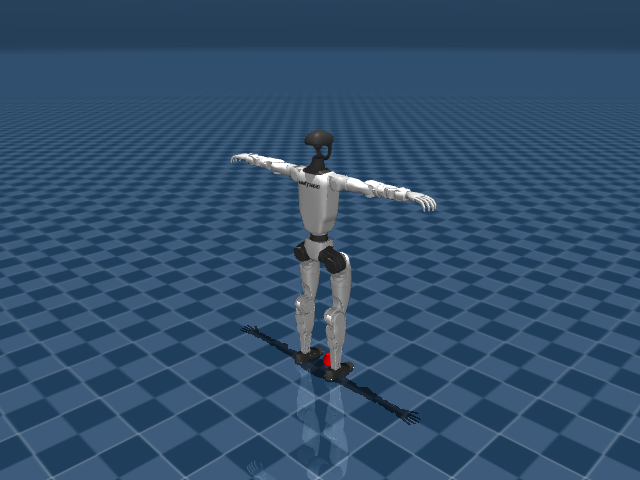

✅ Displayed MuJoCo rendered image of the Your Pose


In [11]:
from tkinter import N

def create_pose():
    """
    Create a T-pose configuration for the G1 robot.
    Returns DOF positions relative to default pose.
    
    Joint order (from common.py):
    0-5: left leg (hip_pitch, hip_roll, hip_yaw, knee, ankle_pitch, ankle_roll)
    6-11: right leg
    12-14: waist (yaw, roll, pitch)
    15-17: left shoulder (pitch, roll, yaw)
    18: left elbow
    19-21: left wrist (roll, pitch, yaw)
    22-24: right shoulder (pitch, roll, yaw)
    25: right elbow
    26-28: right wrist (roll, pitch, yaw)
    """
    # Initialize with zeros (default pose)
    pose = np.zeros(29, dtype=np.float32)
    # pose[0] = 0.0   # left_hip_pitch_joint: default
    # pose[1] = 0.0   # left_hip_roll_joint: default
    # pose[2] = 0.0   # left_hip_yaw_joint: default
    # pose[3] = 0.0   # left_knee_joint: default
    # pose[4] = 0.0   # left_ankle_pitch_joint: default
    # pose[5] = 0.0   # left_ankle_roll_joint: default
    # pose[6] = 0.0   # right_hip_pitch_joint: default
    # pose[7] = 0.0   # right_hip_roll_joint: default
    # pose[8] = 0.0   # right_hip_yaw_joint: default
    # pose[9] = 0.0   # right_knee_joint: default
    # pose[10] = 0.0   # right_ankle_pitch_joint: default
    # pose[11] = 0.0   # right_ankle_roll_joint: default
    
    
    
    # Left arm (indices 15-21)
    pose[15] = 0.0   # left_shoulder_pitch_joint: slightly up
    pose[16] = 1.6   # left_shoulder_roll_joint: abducted (arm out to side)
    pose[17] = 0.0   # left_shoulder_yaw_joint: default
    pose[18] = 1.6   # left_elbow_joint: straight
    pose[19] = 0.0   # left_wrist_roll_joint: default
    pose[20] = 0.0   # left_wrist_pitch_joint: default
    pose[21] = 0.0   # left_wrist_yaw_joint: default
    
    # Right arm (indices 22-28)
    pose[22] = 0.0   # right_shoulder_pitch_joint: slightly up
    pose[23] = -1.6  # right_shoulder_roll_joint: abducted (arm out to side, opposite direction)
    pose[24] = 0.0   # right_shoulder_yaw_joint: default
    pose[25] = 1.6   # right_elbow_joint: straight
    pose[26] = 0.0   # right_wrist_roll_joint: default
    pose[27] = 0.0   # right_wrist_pitch_joint: default
    pose[28] = 0.0   # right_wrist_yaw_joint: default
    
    return pose

# Create pose configuration
print(f"Creating Pose configuration...")
pose_dof = create_pose()
# pose_batch = np.tile(pose_dof, (num_samples, 1))
# Generate MuJoCo images and convert to next_obs
env.reset()
env.set_state(
    dof_positions=pose_dof,
)
image = env.get_image()
next_obs_inference = env._create_observation_backward()

# Display the MuJoCo rendered image directly
print(f"\n🖼️  MuJoCo Rendered Image:")
# Convert numpy array to PIL Image and display
img = PILImage.fromarray(image)
display(img)
print(f"✅ Displayed MuJoCo rendered image of the Your Pose")




### 🔍 Understanding & Perform Goal Inference

The `model.goal_inference()` method works by:
1. **Backward mapping**: Uses `model.backward_map(target_obs)` to infer latent `z` from the target observation
2. **Projection**: Projects the inferred `z` onto a hypersphere using `model.project_z(z)`

This process finds the latent `z` that, when used with the policy, drives the robot toward the target state.


In [12]:
# No use, just show example
def goal_inference(self, next_obs: torch.Tensor | dict[str, torch.Tensor]) -> torch.Tensor:
    z = self.backward_map(next_obs)
    return self.project_z(z)

z_goal = model.goal_inference(next_obs_inference)
print(f"\n✅ Inferred latent z from T-pose!")


✅ Inferred latent z from T-pose!



### Visualize Goal-Directed Behavior

Now let's visualize the robot controlled by the goal-inferred latent `z`. The robot should attempt to reach the target pose (T-pose in this example).

In [ ]:
# Initialize environment with goal z (or use z from reward/tracking inference)
z_to_use = z_goal[0] if len(z_goal.shape) > 1 else z_goal

# Reset environment
env.video_path = "videos/goal_inference_simulation.mp4"
obs = env.reset()
print("Environment reset!")
print(f"Initial observation keys: {list(obs.keys())}")
print(f"Initial root height: {env.mjd.qpos[2]:.4f}")
print()

# Run simulation for a few steps
num_steps = 300
print(f"Running {num_steps} steps...")
print()

for step in range(num_steps):
    # Get action from policy (pass latent_z as parameter)
    action = get_action_from_policy(model, obs, z_to_use)
    
    # Step environment
    obs, next_obs, reward, info = env.step(action)
    
    # Use next_obs for next iteration
    obs = next_obs
    
    # Print info every 10 steps
    if step % 100 == 0:
        print(f"Step {step}.")
print(env.mjd.qpos[7:] - pose_dof)
print("Simulation complete!")

# Save video
if env.enable_video:
    env.save_video()
    print(f"🎥 Video saved to: {env.video_path}")
    
    # Display video in notebook
    print("\n📹 Video Preview:")
    print(f"Video fps: {env.video_fps}")
    display(Video(env.video_path, width=640, height=480))


Environment reset!
Initial observation keys: ['state', 'history_actor', 'last_action', 'privileged_state']
Initial root height: 0.7930

Running 300 steps...

Step 0.


/var/folders/ph/vp01txj919bdr9qfh3vcr0d40000gn/T/ipykernel_18722/1061178654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_torch = tree_map(lambda x: torch.tensor(x).unsqueeze(0), obs)


Step 100.
Step 200.
[-0.077487   -0.03168813  0.04212614  0.2424512  -0.14412351  0.02831254
 -0.08887451 -0.05678216  0.02518464  0.2879158  -0.17795449  0.04942105
  0.00330188 -0.01563806 -0.00465557  0.24580252  0.00994314  0.53619202
 -0.29191774  0.21473691  0.203566    0.25918156 -0.03071688  0.00574879
 -0.20692834 -0.45163878 -0.27008572  0.15716695 -0.18586692]
Simulation complete!
Attempting to save as GIF instead, or install with: pip install imageio[ffmpeg]
Will save as: videos/goal_inference_simulation.gif
Saving 300 frames to videos/goal_inference_simulation.gif...
Error saving video: local variable 'imageio' referenced before assignment
🎥 Video saved to: videos/goal_inference_simulation.mp4

📹 Video Preview:
Video fps: 50


## 📹 3. Tracking Inference

Tracking inference allows the robot to follow a reference motion trajectory. Unlike reward and goal inference which produce a single `z`, tracking inference produces a **sequence of `z` values** (one for each timestep) that makes the robot track the reference motion.

### 🔑 Implementation Steps

1. ✅ **Load reference motion data** (e.g., from LAFAN dataset, motion capture, or keyframe animations)
2. ✅ **Convert motion to observations** for each frame
3. ✅ **Infer latent `z` sequence** using `model.tracking_inference()`
4. ✅ **Control robot** using the sequence of `z` values to track the motion


In [ ]:
# Load the motion data and visualize it
from tkinter import N
MOTION_DATA_FILE = "dance1_subject2_50_jpos.npz"
frames_start, frames_end = 0, 1000
NUM_FRAMES = frames_end - frames_start
motion_data = np.load(MOTION_DATA_FILE)

print("📊 Motion Data Information:")
print(f"Keys: {list(motion_data.keys())}")
print(f"Number of frames: {motion_data['body_positions'].shape[0]}")
print(f"Cut into {NUM_FRAMES} frames")
print(f"FPS: {motion_data['fps']}")

# Visualize the motion using MuJoCo
print("\n🎬 Visualizing motion in MuJoCo...")

# Get motion data
body_positions = motion_data['body_positions'][frames_start:frames_end, :, :]
body_rotations = motion_data['body_rotations'][frames_start:frames_end, :, :]
dof_positions = motion_data['dof_positions'][frames_start:frames_end, :]

# Sample every Nth frame for faster visualization (adjust as needed)
sample_rate = max(1, NUM_FRAMES // 1000)  # Limit to 1000 frames
frames_to_show = list(range(0, NUM_FRAMES, sample_rate))
# frames_to_show = [i+frames_start for i in frames_to_show]

print(f"Showing {len(frames_to_show)} frames (sampling every {sample_rate} frames)")

# Enable video recording and set up renderer
env.enable_video = True
env.video_path = os.path.join(VIDEO_DIR, "motion_visualization.mp4")
env.video_fps = float(motion_data['fps'])  # Convert to Python float

# Reset environment (this will clear frames)
env.reset()

# Animate the motion
next_obs_list = []
for frame_idx in frames_to_show:
    # Set root position and rotation
    root_pos = body_positions[frame_idx, 0, :]  # Pelvis position
    root_quat = body_rotations[frame_idx, 0, :]  # Pelvis rotation [w, x, y, z]
    dof_pos = dof_positions[frame_idx, :]

    if frame_idx > 0:
        dof_vel = (dof_positions[frame_idx, :] - dof_positions[frame_idx - 1, :]) / (1 / motion_data['fps'])
        root_vel = (body_positions[frame_idx, 0, :] - body_positions[frame_idx - 1, 0, :]) / (1 / motion_data['fps'])
        from env import calc_angular_velocity
        root_ang_vel = calc_angular_velocity(body_rotations[frame_idx, 0, :], body_rotations[frame_idx - 1, 0, :], 1 / motion_data['fps'])
    else:
        dof_vel = np.zeros(29, dtype=np.float32)
        root_vel = np.zeros(3, dtype=np.float32)
        root_ang_vel = np.zeros(3, dtype=np.float32)
    
    # Set state in MuJoCo
    # Note: root_vel and root_ang_vel are global velocity and angular velocity of the pelvis
    # Note: root_quat is the pelvis rotation in [w, x, y, z] format
    env.set_state(
        dof_positions=dof_pos,
        dof_velocities=dof_vel,
        root_quat=root_quat,
        root_pos=root_pos,
        root_vel=root_vel,
        root_ang_vel=root_ang_vel
    )
    
    # Render and capture frame for video (IMPORTANT: append to frames list)
    if env.enable_video and env.renderer is not None and env.camera is not None:
        env.renderer.update_scene(env.mjd, camera=env.camera)
        pixels = env.renderer.render()
        env.frames.append(pixels)  # This was missing in the original code!
    next_obs_list.append(env._create_observation_backward())

# Save video
if env.enable_video and len(env.frames) > 0:
    env.save_video()
    print(f"🎥 Video saved to: {env.video_path}")
    
    # Display video in notebook
    print("\n📹 Video Preview:")

    display(Video(env.video_path, width=640, height=480))
else:
    print("⚠️  No frames were recorded. Video recording may not be enabled.")

📊 Motion Data Information:
Keys: ['body_positions', 'body_rotations', 'dof_positions', 'fps', 'dof_names']
Number of frames: 6574
Cut into 1000 frames
FPS: 50.0

🎬 Visualizing motion in MuJoCo...
Showing 1000 frames (sampling every 1 frames)
Attempting to save as GIF instead, or install with: pip install imageio[ffmpeg]
Will save as: videos/motion_visualization.gif
Saving 1000 frames to videos/motion_visualization.gif...
Error saving video: local variable 'imageio' referenced before assignment
🎥 Video saved to: videos/motion_visualization.mp4

📹 Video Preview:


### ▶️ Run Tracking Inference




We give an example to do tracking inference by `model.tracking_inference()`. It use an average latent over `seq_length`(same as training) window size.  


In [15]:
# No use, just show example
def tracking_inference(self, next_obs: torch.Tensor | dict[str, torch.Tensor]) -> torch.Tensor:
    z = self.backward_map(next_obs)
    for step in range(z.shape[0]):
        end_idx = min(step + self.cfg.seq_length, z.shape[0])
        z[step] = z[step:end_idx].mean(dim=0)
    return self.project_z(z)

print("Check the window size: model.cfg.seq_length =", model.cfg.seq_length)

Check the window size: model.cfg.seq_length = 8


This means you view "tracking" as a task to optimize 8 step cumulative goal-reaching reward.    
Of course, you can create your tracking inference functions:

In [16]:
def tracking_inference_discounted_cumulative(model, next_obs: torch.Tensor | dict[str, torch.Tensor], num_steps: int, discount: float) -> torch.Tensor:
    """
    Compute discounted cumulative tracking inference.
    
    For each timestep i, compute a discounted weighted average of z values in the window [i, i+num_steps).
    More recent values in the window have higher weight (discount^0 = 1.0), older values have lower weight (discount^k).
    
    Args:
        model: BFM-Zero model
        next_obs: Observations (sequence)
        num_steps: Window size for averaging
        discount: Discount factor (0 < discount <= 1). Higher values give more weight to future timesteps.
    
    Returns:
        z_discounted: Discounted cumulative z values
    """
    z = model.backward_map(next_obs)
    z_discounted = torch.zeros_like(z)
    
    for i in range(z.shape[0]):
        end_idx = min(i + num_steps, z.shape[0])
        # Compute discounted weights for values in window [i, end_idx)
        # Weight decreases as we look further into the future: weight[j] = discount^(j-i)
        weights = torch.tensor([discount ** (j - i) for j in range(i, end_idx)], 
                              dtype=z.dtype, device=z.device)
        weights = weights / weights.sum()  # Normalize to sum to 1 (weighted average)
        
        # Compute weighted average of z values in the window
        z_discounted[i] = (z[i:end_idx] * weights.unsqueeze(-1)).sum(dim=0)
    
    return model.project_z(z_discounted)


Execute the function to infer latent z from motion tracking:

In [17]:
next_obs_inference = {}
for k in next_obs_list[0].keys():
    next_obs_inference[k] = torch.cat([next_obs_list[i][k] for i in range(len(next_obs_list))], dim=0)

z_tracking = model.tracking_inference(next_obs_inference)
z_custumized = tracking_inference_discounted_cumulative(model, next_obs_inference, 8, 1)

print("z_custumized:", z_custumized)
print("z_tracking:", z_tracking)

assert torch.allclose(z_custumized, z_tracking)
print("✅ z_custumized == z_tracking")


z_custumized: tensor([[ 0.0783, -1.2304, -0.1960,  ..., -1.1334, -0.5113,  0.4105],
        [ 0.1196, -1.2242, -0.0099,  ..., -1.1321, -0.5522,  0.3190],
        [ 0.0742, -1.1921, -0.0382,  ..., -1.1482, -0.6191,  0.2660],
        ...,
        [ 0.8599,  1.2148,  0.1692,  ...,  0.5178,  1.0466,  0.6117],
        [ 0.8346,  1.1928,  0.1514,  ...,  0.5225,  0.9409,  0.5010],
        [ 0.7833,  1.1815,  0.1208,  ...,  0.5405,  0.8529,  0.3689]])
z_tracking: tensor([[ 0.0783, -1.2304, -0.1960,  ..., -1.1334, -0.5113,  0.4105],
        [ 0.1196, -1.2242, -0.0099,  ..., -1.1321, -0.5522,  0.3190],
        [ 0.0742, -1.1921, -0.0382,  ..., -1.1482, -0.6191,  0.2660],
        ...,
        [ 0.8599,  1.2148,  0.1692,  ...,  0.5178,  1.0466,  0.6117],
        [ 0.8346,  1.1928,  0.1514,  ...,  0.5225,  0.9409,  0.5010],
        [ 0.7833,  1.1815,  0.1208,  ...,  0.5405,  0.8529,  0.3689]])
✅ z_custumized == z_tracking


In [18]:
# Initialize environment with goal z (or use z from reward/tracking inference)
z_to_use  = z_custumized = tracking_inference_discounted_cumulative(model, next_obs_inference, 1, 1)

# Reset environment
env.video_path = "videos/tracking_inference_simulation.mp4"
obs = env.reset()
env.video_fps = 50
print("Environment reset!")
print(f"Initial observation keys: {list(obs.keys())}")
print(f"Initial root height: {env.mjd.qpos[2]:.4f}")
print()

# Run simulation for a few steps
num_steps = min(z_to_use.shape[0], 1000)
print(f"Running {num_steps} steps...")
print()

for step in range(num_steps):
    # Get action from policy (pass latent_z as parameter)
    action = get_action_from_policy(model, obs, z_to_use[step])
    obs, next_obs, reward, info = env.step(action)
    obs = next_obs
    if step % 100 == 0:
        print(f"Step {step}.")

print("Simulation complete!")

# Save video
if env.enable_video:
    env.save_video()
    print(f"🎥 Video saved to: {env.video_path}")
    
    # Display video in notebook
    print("\n📹 Video Preview:")
    print(f"Video fps: {env.video_fps}")
    display(Video(env.video_path, width=640, height=480))

Environment reset!
Initial observation keys: ['state', 'history_actor', 'last_action', 'privileged_state']
Initial root height: 0.7930

Running 1000 steps...

Step 0.


/var/folders/ph/vp01txj919bdr9qfh3vcr0d40000gn/T/ipykernel_18722/1061178654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_torch = tree_map(lambda x: torch.tensor(x).unsqueeze(0), obs)


Step 100.
Step 200.
Step 300.
Step 400.
Step 500.
Step 600.
Step 700.
Step 800.
Step 900.
Simulation complete!
Attempting to save as GIF instead, or install with: pip install imageio[ffmpeg]
Will save as: videos/tracking_inference_simulation.gif
Saving 1000 frames to videos/tracking_inference_simulation.gif...
Error saving video: local variable 'imageio' referenced before assignment
🎥 Video saved to: videos/tracking_inference_simulation.mp4

📹 Video Preview:
Video fps: 50


---

## 📤 Export to ONNX

After inferring latent `z`, you can export the policy to **ONNX format** for deployment on real robots or edge devices.

### 🎯 Why Export to ONNX?

- 🤖 **Real Robot Deployment**: Run inference on embedded systems without PyTorch dependencies
- ⚡ **Faster Inference**: ONNX Runtime is optimized for production and often faster than PyTorch
- 🔧 **Cross-Platform**: Works on various hardware (CPU, GPU, edge devices, mobile)


### 📝 Export Function

The following function exports the policy as an ONNX model. It wraps the model to handle both tensor and dictionary observation formats automatically.

**Note**: The export process may take a few minutes. Set `verbose=False` in `torch.onnx.export()` to speed it up.

In [19]:
def export_policy_as_onnx(inference_model, path, exported_policy_name, example_obs_dict):
    from torch import nn
    import torch
    import copy

    os.makedirs(path, exist_ok=True)
    path = os.path.join(path, exported_policy_name)
    inference_model = inference_model.eval()
    actor = copy.deepcopy(inference_model).to("cpu")

    class PPOWrapper(nn.Module):
        def __init__(self, actor):
            """
            model: The original PyTorch model.
            input_keys: List of input names as keys for the input dictionary.
            """
            super(PPOWrapper, self).__init__()
            self.actor = actor

        def forward(self, actor_obs):
            """
            Dynamically creates a dictionary from the input keys and args.
            """
            actor_obs, ctx = actor_obs[:, :-256], actor_obs[:, -256:]
            state = actor_obs[:, :64]
            last_action = actor_obs[:, 64:64+29]
            history_actor = actor_obs[:, 64+29:64+29+372]
            privileged_state = actor_obs[:, 64+29+372:]
            observation = {
                "state": state,
                "history_actor": history_actor,
                "last_action": last_action,
                "privileged_state": privileged_state
            }

            return self.actor.act(observation, ctx)

    wrapper = PPOWrapper(actor)
    example_input_list = example_obs_dict["actor_obs"]
    torch.onnx.export(
        wrapper,
        example_input_list,  # Pass x1 and x2 as separate inputs
        path,
        verbose=True,
        input_names=["actor_obs"],  # Specify the input names
        output_names=["action"],  # Name the output
        opset_version=13,  # Specify the opset version, if needed
    )

In [20]:
from pathlib import Path


OUTPUT_DIR = Path("./metamotivo-aux/oct7_base/checkpoint")
model = FBcprAuxModel.load(MODEL_PATH, device="cpu")
# export_policy_as_onnx(model, OUTPUT_DIR, "model.onnx", {"actor_obs": torch.randn(1, 64 + 372 + 29 + 463 + model.cfg.archi.z_dim)})
print(f"Exporting model to {OUTPUT_DIR}/model.onnx")

Exporting model to metamotivo-aux/oct7_base/checkpoint/model.onnx
